In [1]:
# Import
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using Device: {device}")

stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

print("Downloading CIFAR-10...")
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_basic)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_basic)



train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Dataset Split Completed:")
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Using Device: cuda


100%|██████████| 170M/170M [00:06<00:00, 26.5MB/s]


Dataset Split Completed:
Training Samples: 45000
Validation Samples: 5000
Test Samples: 10000


In [2]:
# Training Functions
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10, name="Model"):
    print(f"Starting Training: {name}")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training Loop
        loop = tqdm(train_loader, leave=False)
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

        train_acc = 100. * correct / total
        train_loss = running_loss / len(train_loader)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_acc = 100. * correct / total
        val_loss = val_loss / len(val_loader)

        if scheduler:
            scheduler.step()

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    # Save Model
    torch.save(model.state_dict(), f"{name}_cifar10.pth")
    return history

def plot_history(history, title="Training History"):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


Starting Training: Level1_Baseline


Epoch 1: Train Acc: 70.97% | Val Acc: 78.18%


Epoch 2: Train Acc: 78.64% | Val Acc: 79.92%


Epoch 3: Train Acc: 79.76% | Val Acc: 80.20%


Epoch 4: Train Acc: 80.34% | Val Acc: 80.62%


Epoch 5: Train Acc: 80.73% | Val Acc: 80.54%


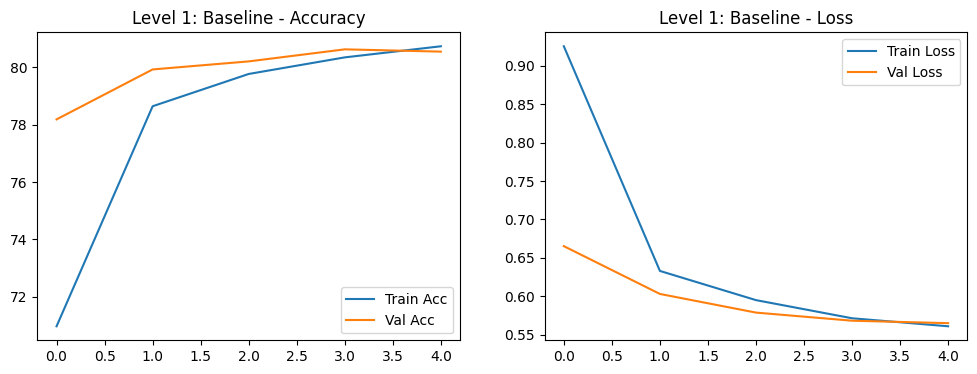

In [3]:
# LEVEL 1: BASELINE (Transfer Learning)
from torchvision import models

model_l1 = models.resnet18(pretrained=True)

for param in model_l1.parameters():
    param.requires_grad = False

num_ftrs = model_l1.fc.in_features
model_l1.fc = nn.Linear(num_ftrs, 10) # CIFAR-10 has 10 classes
model_l1 = model_l1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_l1 = optim.Adam(model_l1.fc.parameters(), lr=0.001)

# Train Level 1
history_l1 = train_model(model_l1, train_loader, val_loader, criterion, optimizer_l1,
                        num_epochs=5, name="Level1_Baseline")

plot_history(history_l1, title="Level 1: Baseline")

Unfreezing model for Fine-Tuning to hit >85%...
Starting Training: Level1_FineTuned


Epoch 1: Train Acc: 90.82% | Val Acc: 93.80%


Epoch 2: Train Acc: 97.92% | Val Acc: 93.50%


Epoch 3: Train Acc: 99.50% | Val Acc: 95.00%


Epoch 4: Train Acc: 99.75% | Val Acc: 94.06%


Epoch 5: Train Acc: 99.62% | Val Acc: 93.82%


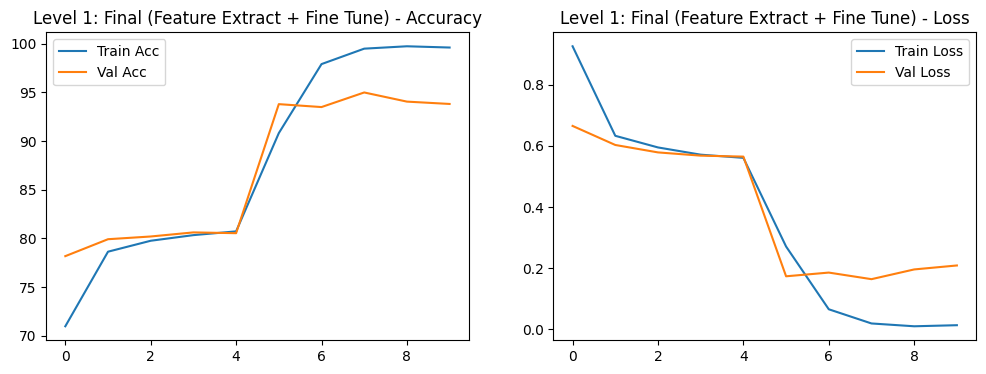

In [4]:
# Unfreezing the model
print("Unfreezing model for Fine-Tuning to hit >85%...")

for param in model_l1.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model_l1.parameters(), lr=1e-4)

history_ft = train_model(model_l1, train_loader, val_loader, criterion, optimizer_ft,
                        num_epochs=5, name="Level1_FineTuned")

# Combine histories for plotting
full_history = {
    'train_acc': history_l1['train_acc'] + history_ft['train_acc'],
    'val_acc': history_l1['val_acc'] + history_ft['val_acc'],
    'train_loss': history_l1['train_loss'] + history_ft['train_loss'],
    'val_loss': history_l1['val_loss'] + history_ft['val_loss']
}

plot_history(full_history, title="Level 1: Final (Feature Extract + Fine Tune)")

Starting Training: Level2_Augmentation


Epoch 1: Train Acc: 87.20% | Val Acc: 95.16%


Epoch 2: Train Acc: 94.62% | Val Acc: 96.58%


Epoch 3: Train Acc: 96.52% | Val Acc: 97.78%


Epoch 4: Train Acc: 97.45% | Val Acc: 98.64%


Epoch 5: Train Acc: 98.77% | Val Acc: 99.34%


Epoch 6: Train Acc: 99.19% | Val Acc: 99.50%


Epoch 7: Train Acc: 99.30% | Val Acc: 99.42%


Epoch 8: Train Acc: 99.46% | Val Acc: 99.50%


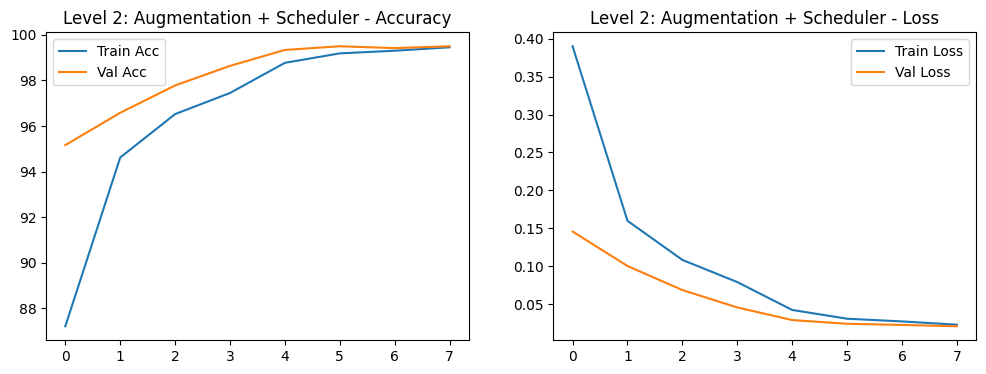

In [5]:
# LEVEL 2: INTERMEDIATE TECHNIQUES (Augmentation + Regularization)

transform_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

train_dataset_aug = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform_aug)

train_dataset_l2, val_dataset_l2 = random_split(train_dataset_aug, [train_size, val_size])

train_loader_l2 = DataLoader(train_dataset_l2, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

model_l2 = models.resnet18(pretrained=True)
model_l2.fc = nn.Linear(model_l2.fc.in_features, 10)
model_l2 = model_l2.to(device)

optimizer_l2 = optim.Adam(model_l2.parameters(), lr=1e-4, weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer_l2, step_size=4, gamma=0.1)

history_l2 = train_model(model_l2, train_loader_l2, val_loader, criterion, optimizer_l2,
                        scheduler=scheduler, num_epochs=8, name="Level2_Augmentation")

plot_history(history_l2, title="Level 2: Augmentation + Scheduler")

In [7]:
# LEVEL 3: CUSTOM ARCHITECTURE (ResNet + Custom Head)


import time

print("--- STARTING LEVEL 3 SETUP ---")

class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.backbone = models.resnet18(pretrained=True)

        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        self.custom_head = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.custom_head(x)
        return x

model_l3 = CustomResNet().to(device)
print("Model initialized: CustomResNet with Dual-Layer Head")


optimizer_l3 = optim.Adam(model_l3.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler_l3 = optim.lr_scheduler.OneCycleLR(optimizer_l3, max_lr=0.001,
                                            steps_per_epoch=len(train_loader_l2),
                                            epochs=10)

print("Starting Training (10 Epochs)...")
history_l3 = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}
num_epochs = 3

for epoch in range(num_epochs):
    start_time = time.time()
    model_l3.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader_l2):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_l3.zero_grad()
        outputs = model_l3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_l3.step()
        scheduler_l3.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % 100 == 0:
            print(f"  > Epoch {epoch+1} Batch {i+1}/{len(train_loader_l2)} - Loss: {loss.item():.4f}")

    model_l3.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_l3(inputs)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    epoch_acc = 100 * correct / total
    val_acc = 100 * val_correct / val_total
    time_elapsed = time.time() - start_time

    print(f"EPOCH {epoch+1}/{num_epochs} FINISHED: Train Acc: {epoch_acc:.2f}% | Val Acc: {val_acc:.2f}% | Time: {time_elapsed:.0f}s")

    history_l3['train_acc'].append(epoch_acc)
    history_l3['val_acc'].append(val_acc)

# Save Level 3
torch.save(model_l3.state_dict(), "Level3_Custom_cifar10.pth")
print("Level 3 Model Saved.")

--- STARTING LEVEL 3 SETUP ---
Model initialized: CustomResNet with Dual-Layer Head
Starting Training (10 Epochs)...
  > Epoch 1 Batch 100/352 - Loss: 0.8323
  > Epoch 1 Batch 200/352 - Loss: 0.3683
  > Epoch 1 Batch 300/352 - Loss: 0.3048
EPOCH 1/3 FINISHED: Train Acc: 78.49% | Val Acc: 90.50% | Time: 200s
  > Epoch 2 Batch 100/352 - Loss: 0.3386
  > Epoch 2 Batch 200/352 - Loss: 0.2985
  > Epoch 2 Batch 300/352 - Loss: 0.4475
EPOCH 2/3 FINISHED: Train Acc: 88.94% | Val Acc: 90.60% | Time: 210s
  > Epoch 3 Batch 100/352 - Loss: 0.5117
  > Epoch 3 Batch 200/352 - Loss: 0.3564
  > Epoch 3 Batch 300/352 - Loss: 0.2208
EPOCH 3/3 FINISHED: Train Acc: 88.51% | Val Acc: 89.70% | Time: 210s
Level 3 Model Saved.


In [8]:
# LEVEL 4: ENSEMBLE CHECK
print("--- STARTING LEVEL 4 ENSEMBLE ---")

# 1. Load Level 2 Model
print("Loading Level 2 Model...")
try:
    m2 = models.resnet18(pretrained=False)
    m2.fc = nn.Linear(512, 10)
    m2.load_state_dict(torch.load("Level2_Augmentation_cifar10.pth"))
    m2 = m2.to(device)
    m2.eval()
    print("Level 2 Model Loaded.")
except Exception as e:
    print(f"ERROR Loading Level 2: {e}")
    print("Did you let Cell 4 finish?")

# 2. Load Level 3 Model
print("Loading Level 3 Model...")
try:
    m3 = CustomResNet()
    m3.load_state_dict(torch.load("Level3_Custom_cifar10.pth"))
    m3 = m3.to(device)
    m3.eval()
    print("Level 3 Model Loaded.")
except Exception as e:
    print(f"ERROR Loading Level 3: {e}")

# 3. Run Ensemble
print("Running Predictions on Test Set (This takes ~30 seconds)...")
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        out2 = m2(inputs)
        out3 = m3(inputs)

        avg_out = (out2 + out3) / 2.0

        _, predicted = avg_out.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_acc = 100 * correct / total
print(f"FINAL LEVEL 4 ACCURACY: {final_acc:.2f}%")


--- STARTING LEVEL 4 ENSEMBLE ---
Loading Level 2 Model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Level 2 Model Loaded.
Loading Level 3 Model...
Level 3 Model Loaded.
Running Predictions on Test Set (This takes ~30 seconds)...
FINAL LEVEL 4 ACCURACY: 95.38%


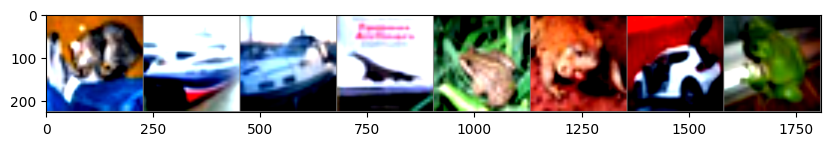

GroundTruth:  cat   ship  ship  airplane frog  frog  automobile frog 
Predicted:    cat   ship  ship  airplane frog  frog  automobile frog 


In [9]:
# VISUALIZATION
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

plt.figure(figsize=(10,4))
imshow(torchvision.utils.make_grid(images[:8]))
print('GroundTruth: ', ' '.join(f'{test_dataset.classes[labels[j]]:5s}' for j in range(8)))

images = images.to(device)
outputs = m3(images)
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{test_dataset.classes[predicted[j]]:5s}' for j in range(8)))

Visualizing Results for Level 3 Model...
Generating predictions for analysis...


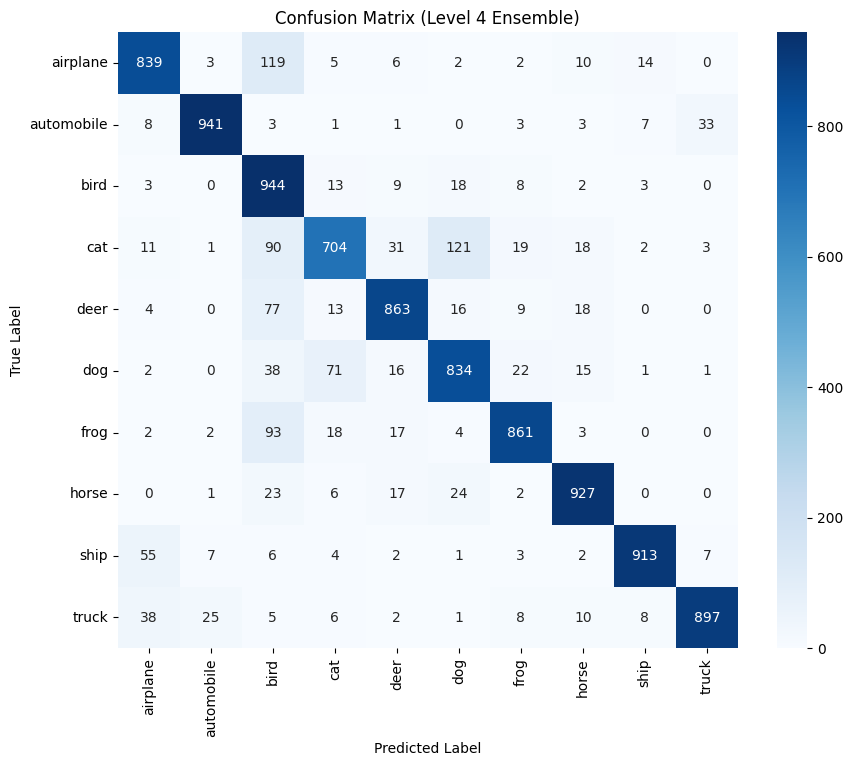

/tmp/ipython-input-922492083.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classes, y=class_acc, palette='viridis')


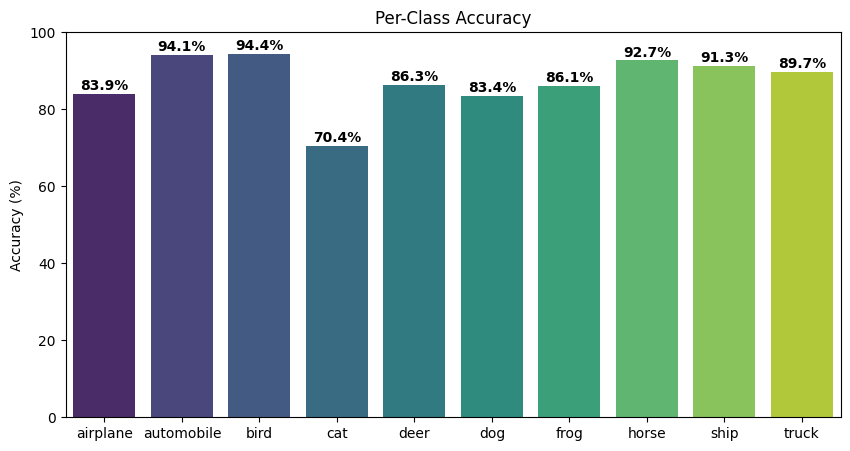


Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.87      0.84      0.86      1000
  automobile       0.96      0.94      0.95      1000
        bird       0.68      0.94      0.79      1000
         cat       0.84      0.70      0.76      1000
        deer       0.90      0.86      0.88      1000
         dog       0.82      0.83      0.83      1000
        frog       0.92      0.86      0.89      1000
       horse       0.92      0.93      0.92      1000
        ship       0.96      0.91      0.94      1000
       truck       0.95      0.90      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000


Top Misclassified Examples:


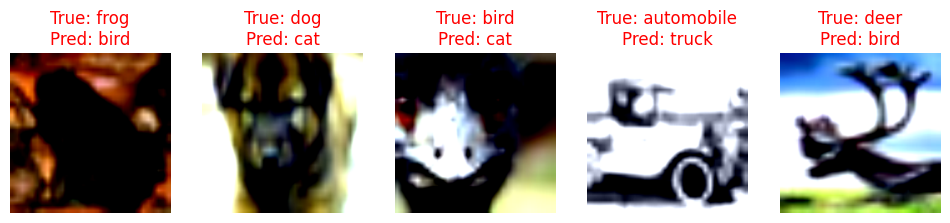

In [10]:
# VISUALIZATION & ANALYSIS
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def generate_visualizations(model, loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    print("Generating predictions for analysis...")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix (Level 4 Ensemble)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm_norm.diagonal() * 100

    plt.figure(figsize=(10, 5))
    sns.barplot(x=classes, y=class_acc, palette='viridis')
    plt.title('Per-Class Accuracy')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    for i, v in enumerate(class_acc):
        plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontweight='bold')
    plt.show()

    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    return all_preds, all_labels

print("Visualizing Results for Level 3 Model...")
preds, targets = generate_visualizations(m3, test_loader, test_dataset.classes)

print("\nTop Misclassified Examples:")
model_l3.eval()
count = 0
plt.figure(figsize=(12, 6))

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model_l3(images)
_, predicted = torch.max(outputs, 1)

failures = predicted != labels
fail_imgs = images[failures]
fail_preds = predicted[failures]
fail_labels = labels[failures]

if len(fail_imgs) > 0:
    for i in range(min(5, len(fail_imgs))):
        img = fail_imgs[i].cpu() / 2 + 0.5 # unnormalize
        npimg = img.numpy()
        plt.subplot(1, 5, i+1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"True: {test_dataset.classes[fail_labels[i]]}\nPred: {test_dataset.classes[fail_preds[i]]}", color='red')
        plt.axis('off')
    plt.show()
else:
    print(" No failures in this batch. ")